In [1]:
import rlssm
import pandas as pd
import os

#### Import the data of a single subject

In [2]:
data = pd.read_csv('../../data/data_experiment.csv', index_col=0)
data = data[data.participant == 10].reset_index(drop=True)

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,10,1,1,61,52,4,3,1,1.285418,0
1,10,1,2,54,37,4,2,1,1.577622,0
2,10,1,3,51,51,4,3,2,1.564731,0
3,10,1,4,50,35,3,1,2,1.217245,1
4,10,1,5,59,50,4,2,3,1.929781,0


#### Initialise the model

In [3]:
model = rlssm.RLModel_2A(hierarchical_levels = 1)

INFO:cmdstanpy:compiling stan file /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A.stan to exe file /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A
INFO:cmdstanpy:compiled model executable: /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A.hpp /Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A.stan
Warning in '/Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A.stan', line 4, column 1: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/khamir/_DecisionMaking/_rlssm/rlssm/rlssm/stan_models/RL_2A/RL_2A.stan', line 7, column 1: Declara

In [4]:
model.family, model.model_label, model.hierarchical_levels

('RL_2A', 'RL_2A', 1)

In [5]:
model.increasing_sensitivity, model.separate_learning_rates

(False, False)

#### Fit

In [6]:
# sampling parameters
n_iter = 500
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options
initial_value_learning = 27.5 # intitial value (Q0)

# bayesian model
alpha_pos_priors = {'mu':0, 'sd':1}

In [7]:
model_fit = model.fit(data, 
                      K, 
                      initial_value_learning,
                      alpha_pos_priors = alpha_pos_priors,
                      print_diagnostics=False,
                      thin = n_thin,
                      iter_warmup = n_iter,
                      iter_sampling = n_iter)

Fitting the model using the priors:
alpha_priors {'mu': 0, 'sd': 1}
sensitivity_priors {'mu': 1, 'sd': 50}
alpha_pos_priors {'mu': 0, 'sd': 1}


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


#### get Rhat

In [9]:
model_fit.rhat.describe()

,rhat
count,482.000000
mean,1.012656
std,0.033282
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.100000


In [10]:
model_fit.rhat.head()

,rhat,variable
name,,
lp__,1.0,lp__
alpha,1.1,alpha
sensitivity,1.0,sensitivity
log_p_t[1],NaN,log_p_t[1]
log_p_t[2],1.0,log_p_t[2]


#### get wAIC

In [11]:
model_fit.waic

{'lppd': -114.05915835520067,
 'p_waic': 1.5988237919260926,
 'waic': 231.31596429425352,
 'waic_se': 16.422830601956324}

### Posteriors

In [12]:
model_fit.samples

,transf_alpha,transf_sensitivity
0,0.001986,5.568520
1,0.001212,6.231550
2,0.001619,6.723150
3,0.001273,5.191480
4,0.001420,5.487250
...,...,...
1995,0.018211,0.652890
1996,0.009265,0.968986
1997,0.007227,1.190070
1998,0.007936,1.385200


In [13]:
model_fit.trial_samples

{'log_p_t': array([[-0.693147  , -0.524929  , -0.516249  , ..., -0.00217016,
         -0.18314   , -0.181826  ],
        [-0.693147  , -0.574639  , -0.568199  , ..., -0.0139536 ,
         -0.28492   , -0.283385  ],
        [-0.693147  , -0.52732   , -0.518692  , ..., -0.00226579,
         -0.185756  , -0.184352  ],
        ...,
        [-0.693147  , -0.559434  , -0.552984  , ..., -0.0143922 ,
         -0.276466  , -0.276386  ],
        [-0.693147  , -0.525866  , -0.518113  , ..., -0.00482905,
         -0.211483  , -0.211575  ],
        [-0.693147  , -0.542352  , -0.534955  , ..., -0.00673046,
         -0.232823  , -0.232352  ]])}

In [14]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

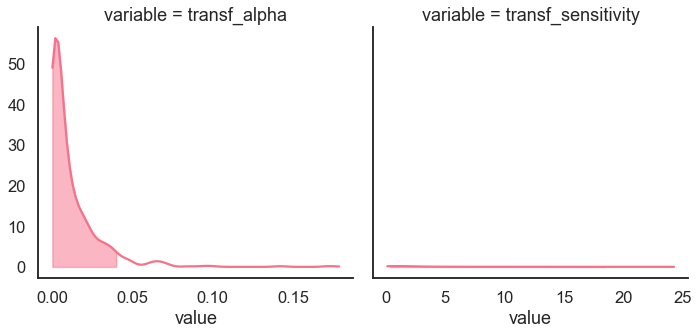

In [15]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

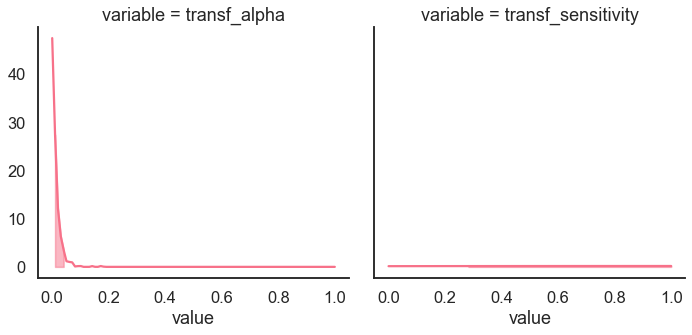

In [16]:
model_fit.plot_posteriors(height=5, show_intervals="BCI", alpha_intervals=.1, clip=(0, 1));

### Posterior predictives

#### Ungrouped

In [17]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=500)

pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 230 231 232 233   
sample                                                 ...                   
1               0   1   1   1   0   1   1   0   0   0  ...   1   1   1   1   
2               0   1   0   1   0   0   1   1   0   1  ...   1   1   1   1   
3               1   1   1   0   1   0   1   1   1   1  ...   1   1   1   1   
4               1   0   1   0   1   0   1   1   1   0  ...   1   0   1   1   
5               1   0   1   0   0   1   1   1   0   1  ...   1   1   1   1   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
496             1   0   1   1   1   1   1   1   1   1  ...   1   1   1   1   
497             1   0   0   1   0   0   1   1   1   0  ...   1   1   1   1   
498             0   1   1   0   1   1   1   1   0   0  ...   1   1   1   1   
499             1   1   0   1   1   0   0   1   1   0  ...   1   1   1   1   
500             0   0   0   1   1   0   0   1   1   1  ...   1   1   1   1   

variable                          
trial    234 235 236 237 238 239  
sample                            
1          1   1   1   1   1   1  
2          1   0   0   1   1   1  
3          1   0   1   1   1   1  
4          1   1   0   1   0   1  
5          1   1   1   1   0   1  
...       ..  ..  ..  ..  ..  ..  
496        1   1   1   1   1   1  
497        1   1   1   1   1   1  
498        1   1   1   1   0   1  
499        1   0   1   1   1   1  
500        1   1   1   1   1   1  

[500 rows x 239 columns]

In [18]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=500)

pp_summary

,mean_accuracy
sample,
1,0.824268
2,0.769874
3,0.774059
4,0.744770
5,0.744770
...,...
496,0.774059
497,0.732218
498,0.707113


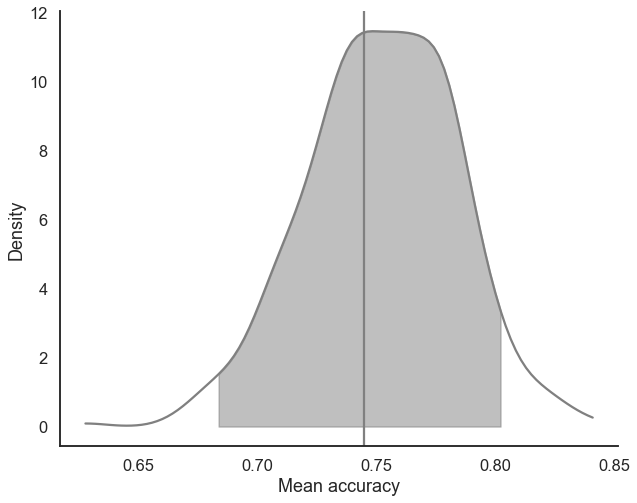

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

#### Grouped

In [20]:
import numpy as np

data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

data.head()

,index,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,choice_pair,block_bins
0,0,10,1,1,61,52,4,3,1,1.285418,0,CD,1
1,1,10,1,2,54,37,4,2,1,1.577622,0,BD,1
2,2,10,1,3,51,51,4,3,2,1.564731,0,CD,1
3,3,10,1,4,50,35,3,1,2,1.217245,1,AC,1
4,4,10,1,5,59,50,4,2,3,1.929781,0,BD,1


In [21]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1           1          AB          1                 0.0
                                   2                 1.0
                                   3                 0.0
                                   4                 0.0
                                   5                 1.0
...                                                  ...
3           8          BD          496               1.0
                                   497               1.0
                                   498               1.0
                                   499               1.0
                                   500               1.0

[46000 rows x 1 columns]

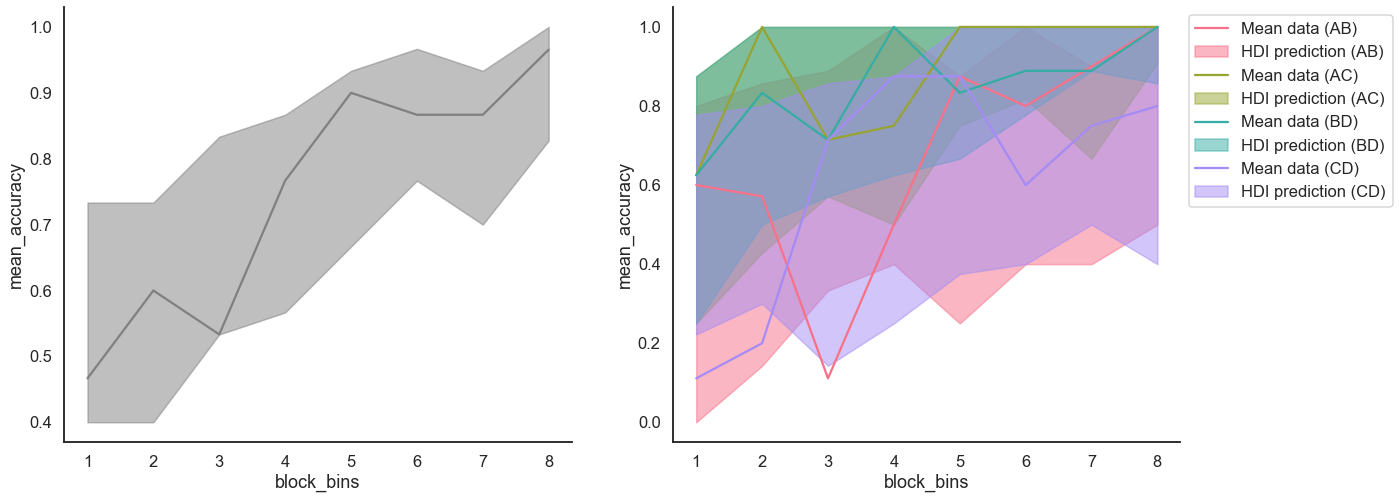

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()